<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import urllib.request


### Datos
Se utilizará el libro Don Quijote en Project Gutenberg

In [2]:
# Fijamos la semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# URL del libro en formato texto plano (UTF-8)
# ID 2000 es Don Quijote en Project Gutenberg
url = 'https://www.gutenberg.org/ebooks/2000.txt.utf-8'
filename = 'quijote.txt'

#Descargar el archivo si no existe
if not os.path.exists(filename):
    print(f"Descargando {filename}...")
    urllib.request.urlretrieve(url, filename)
    print("Descarga completada.")
else:
    print(f"El archivo {filename} ya existe.")

# Leer el texto
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()

# Limpieza de cabeceras y pies de página de Gutenberg
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"

start_idx = text.find(start_marker)
end_idx = text.find(end_marker)


if start_idx != -1 and end_idx != -1:
    start_idx = text.find("\n", start_idx) + 1
    text = text[start_idx:end_idx]

# Normalización
article_text = text.lower()

print(f"\nLongitud total del corpus: {len(article_text)} caracteres")


Descargando quijote.txt...
Descarga completada.

Longitud total del corpus: 2110737 caracteres


In [4]:
# Verificamos la longitud y mostramos fragmentos para confirmar la limpieza
print(f"Longitud del texto: {len(article_text)}")

print("--- Fragmento del inicio ---")
print(article_text[:500])

print("\n--- Fragmento aleatorio del medio ---")
# Tomamos un punto medio aproximado para ver contenido real de la novela
mid_point = len(article_text) // 2
print(article_text[mid_point : mid_point + 500])

Longitud del texto: 2110737
--- Fragmento del inicio ---




el ingenioso hidalgo don quijote de la mancha



por miguel de cervantes saavedra





el ingenioso hidalgo don quijote de la mancha


  
tasa

  
testimonio de las erratas

  
el rey

  
al duque de béjar

  
prólogo

  
al libro de don quijote de la mancha



que trata de la condición y ejercicio del famoso
hidalgo don quijote de la mancha

que trata de la primera salida que de su tierra hizo
el ingenioso don quijote

donde se cuenta la graciosa manera que tuvo don
quijote en armarse cabal

--- Fragmento aleatorio del medio ---
halle desapercebido el enemigo; pero si se tomara mi
consejo, aconsejárale yo que usara de una prevención, de la cual su
majestad la hora de agora debe estar muy ajeno de pensar en ella.

apenas oyó esto el cura, cuando dijo entre sí:

— ¡dios te tenga de su mano, pobre don quijote: que me parece que te
despeñas de la alta cumbre de tu locura hasta el profundo abismo de tu
simplicidad!

mas el barber

## Elegir el tamaño del contexto (ventana de atención)

En este caso, al trabajar con un modelo de lenguaje basado en caracteres, consideramos todo el corpus como un documento continuo. El tamaño del contexto define cuántos caracteres hacia atrás mirará el modelo para predecir el siguiente.


A diferencia de los modelos basados en palabras (donde un contexto de 10 palabras ya puede capturar una frase completa), en los modelos de caracteres necesitamos una ventana mucho mayor para capturar estructuras gramaticales y semánticas significativas.

* **Ventana pequeña (ej. 10):** El modelo solo vería fragmentos sin sentido como "de la man".
* **Ventana amplia (ej. 100):** El modelo puede ver el equivalente a una o dos oraciones completas, lo que le da suficiente información para aprender patrones más complejos.

> **Decisión:** Por esta razón, elegimos `max_context_size = 100` en lugar de un valor menor. Esta elección asegura que el modelo tenga el contexto suficiente para entender la semántica, algo que se perdería con la configuración típica de un modelo de palabras.

Lugo procedemos a identificar todos los caracteres únicos presentes en el texto (letras, números, puntuación), y  creamos dos diccionarios esenciales para la traducción.
    * `char2idx`: para convertir texto a números (entrada del modelo).
    * `idx2char`: para convertir números a texto (salida del modelo, predicciones).

Al trabajar a nivel de carácter, nuestro vocabulario será pequeño (aprox. 60-80 tokens) comparado con un modelo de palabras que tendría miles. Esto hace que el modelo sea mucho más ligero en memoria, aunque asumimos el desafío de que necesitará aprender secuencias más largas para lograr formar sentido.

In [5]:
max_context_size = 100

print(f"Tamaño de contexto definido: {max_context_size} caracteres")

Tamaño de contexto definido: 100 caracteres


In [6]:

# Tokenización por Caracteres

# Crear el vocabulario único de caracteres
chars_vocab = sorted(list(set(article_text)))
vocab_size = len(chars_vocab)

# Mapeos de caracteres a índices y viceversa
char2idx = {char: idx for idx, char in enumerate(chars_vocab)}
idx2char = {idx: char for idx, char in enumerate(chars_vocab)}

print(f"Tamaño del vocabulario de caracteres: {vocab_size}")
print("Caracteres encontrados:", "".join(chars_vocab))

# Función para tokenizar (Texto -> Índices)
def encode_text(text, char_map):
    return [char_map[c] for c in text]

# Tokenizamos todo el corpus
tokenized_text = encode_text(article_text, char2idx)

print(f"\nEjemplo de tokenización:")
print(f"Texto original: '{article_text[:20]}'")
print(f"Índices: {tokenized_text[:20]}")

Tamaño del vocabulario de caracteres: 62
Caracteres encontrados: 
 !"'(),-.01234567:;?]abcdefghijlmnopqrstuvwxyz¡«»¿àáéíïñóùúü—

Ejemplo de tokenización:
Texto original: '



el ingenioso hid'
Índices: [0, 0, 0, 0, 26, 32, 1, 30, 34, 28, 26, 34, 30, 35, 39, 35, 1, 29, 30, 25]


## Organización del dataset (train / validation)

Una vez tokenizado todo el libro en una larga lista de números, necesitamos dividirla para entrenar el modelo.

**División train / validation:**

Separamos el corpus en dos partes. Usaremos el 90% del texto para entrenar y el 10% restante para validar.


**Secuencias de entrada y salida:**

Usaremos la estrategia **Many-to-One** (Muchos a Uno):

1.  **Many (Entrada $X$):** El modelo recibe una secuencia de `max_context_size` caracteres (ej. 100 letras).
2.  **One (Salida $y$):** El modelo debe predecir **un solo caracter**: el que sigue inmediatamente después.

Por tanto, si nuestra ventana es de tamaño $N$, la estrategia es tomar fragmentos de tamaño $N+1$.

Al tener un corpus tan extenso como el Quijote, podemos generar miles de secuencias de entrenamiento simplemente deslizando esta ventana a lo largo del texto, lo que maximiza la cantidad de ejemplos que la red puede ver.

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Convertir texto a tensor
data_tensor = torch.tensor(tokenized_text, dtype=torch.long)

# División Train / Validation
n_split = int(0.9 * len(data_tensor))
train_data = data_tensor[:n_split]
val_data = data_tensor[n_split:]

print(f"Caracteres Train: {len(train_data)} | Val: {len(val_data)}")

# Función para crear secuencias
def create_dataset(text_data, seq_len, step):
    X, y = [], []
    for i in range(0, len(text_data) - seq_len, step):
        X.append(text_data[i : i + seq_len])
        y.append(text_data[i + seq_len])
    return torch.stack(X), torch.stack(y)

print("Generando secuencias...")
X_train, y_train = create_dataset(train_data, max_context_size, step=5)
X_val, y_val = create_dataset(val_data, max_context_size, step=5)

print(f"Secuencias Train: {X_train.shape[0]} | Val: {X_val.shape[0]}")

# DataLoaders
batch_size = 256

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print("DataLoaders listos.")

Caracteres Train: 1899663 | Val: 211074
Generando secuencias...
Secuencias Train: 379913 | Val: 42195
DataLoaders listos.


# Definiendo el modelo

### Definición de la Arquitectura del Modelo


Para abordar la tarea de modelado de lenguaje a nivel de caracteres, se ha diseñado una arquitectura basada en Redes Neuronales Recurrentes (RNN), dada su capacidad intrínseca para procesar datos secuenciales y capturar dependencias temporales.

La arquitectura propuesta consta de los siguientes componentes:

1.  **Capa de Embedding:** Transforma los índices de caracteres (enteros) en vectores densos de dimensión fija (`hidden_dim`). A diferencia de la codificación *One-Hot*, que produce vectores dispersos y de alta dimensionalidad, el embedding denso permite que el modelo aprenda representaciones semánticas de los caracteres durante el entrenamiento, mejorando la eficiencia computacional y la capacidad de generalización.
2.  **Capa Recurrente (RNN/LSTM/GRU):** Es el núcleo del modelo. Procesa la secuencia de embeddings y actualiza su estado oculto en cada paso temporal. Se ha implementado un diseño modular que permite instanciar tres variantes para su comparación empírica:
    * **Simple RNN (Elman):** La forma más básica, útil como línea base.
    * **LSTM (Long Short-Term Memory):** Introduce celdas de memoria y puertas de control para mitigar el problema del desvanecimiento del gradiente, capturando dependencias a largo plazo.
    * **GRU (Gated Recurrent Unit):** Una variante simplificada de LSTM que a menudo ofrece un rendimiento comparable con menor costo computacional.
3.  **Regularización (Dropout):** Se aplica una capa de Dropout a la salida de la red recurrente para prevenir el sobreajuste (*overfitting*), aleatorizando la activación de las neuronas durante el entrenamiento.
4.  **Capa de Salida (Lineal):** Proyecta el estado oculto final de la red recurrente al espacio del vocabulario (tamaño igual al número de caracteres únicos). La salida de esta capa (logits) representa la distribución de probabilidad no normalizada del siguiente caracter.

### Definición de Parámetros y Métricas para la Comparación

Para realizar una comparación justa entre las diferentes arquitecturas recurrentes (Simple RNN, LSTM y GRU), es crucial mantener constantes la mayoría de los hiperparámetros y definir métricas claras.

**1. Profundidad de la Red (Hidden Dimension):**
Se ha establecido una dimensión oculta (`hidden_dim`) de **256** para las tres arquitecturas. Este valor ofrece un buen equilibrio entre capacidad de aprendizaje y costo computacional para un vocabulario pequeño (caracteres). Mantener este valor constante permite atribuir las diferencias en el rendimiento a la arquitectura de la celda (RNN vs LSTM vs GRU) y no al tamaño del modelo. Aunque las LSTM y GRU tienen más parámetros internos que una RNN simple para el mismo `hidden_dim` (debido a sus compuertas), usar la misma dimensión de salida interna hace que las representaciones sean comparables.

**2. Métricas de Evaluación:**
* **Pérdida (Cross-Entropy Loss):** Es la función objetivo que se minimiza durante el entrenamiento. Mide la discrepancia entre la distribución de probabilidad predicha y el caracter real.
* **Perplejidad (Perplexity - PPL):** se toma también al ser  la métrica estándar para modelos de lenguaje.
* **Precisión (Accuracy):** Mide el porcentaje de veces que el modelo acierta exactamente el siguiente caracter. Aunque es útil, en modelos de lenguaje es menos informativa que la perplejidad, ya que no penaliza la incertidumbre si la predicción final es correcta.

**Estrategia Experimental:**
Entrenaremos los tres modelos por el mismo número de épocas (o hasta que actúe el *Early Stopping*) utilizando el mismo conjunto de datos y optimizador (RMSprop), registrando la pérdida y la perplejidad en cada época para su posterior visualización.


Para optimizar el proceso de entrenamiento y evitar el *overfitting*, se ha implementado un mecanismo de **Early Stopping** basado en la métrica de **pérdida de validación (`val_loss`)**.



In [8]:
import torch.nn as nn

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, rnn_type='rnn', num_layers=1, dropout=0.2):
        super(CharRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.rnn_type = rnn_type.lower()
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Capa de Embedding
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # Capa Recurrente
        # Nota: Si num_layers=1, el parámetro dropout de la RNN se ignora (y genera warning).
        # Lo manejamos aplicando dropout explícito después.
        rnn_dropout = dropout if num_layers > 1 else 0

        if self.rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=rnn_dropout)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=rnn_dropout)
        else:
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=rnn_dropout)

        # Capa de Dropout (siempre aplicada antes de la salida)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        out = self.embedding(x)

        # Procesamiento recurrente
        rnn_out, _ = self.rnn(out)

        # Selección del último estado
        last_out = rnn_out[:, -1, :]

        # Dropout explícito y proyección final
        out = self.dropout(last_out)
        out = self.fc(out)

        return out

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de entrenamiento: {device}")

# Instanciación (usamos num_layers=2 para consistencia con el entrenamiento futuro)
model = CharRNN(vocab_size=vocab_size, hidden_dim=256, rnn_type='rnn', num_layers=2, dropout=0.2).to(device)

print("Arquitectura del Modelo:")
print(model)

Dispositivo de entrenamiento: cuda
Arquitectura del Modelo:
CharRNN(
  (embedding): Embedding(62, 256)
  (rnn): RNN(256, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=62, bias=True)
)


In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Configuración de Hiperparámetros
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001

# Configuración de Early Stopping
PATIENCE = 5
MIN_DELTA = 1e-4

# Diccionario para guardar resultados
histories = {}
model_types = ['rnn', 'gru', 'lstm']

print(f"Iniciando entrenamiento comparativo en: {device}")
print("-" * 60)

for m_type in model_types:
    print(f"\n>>> Entrenando Modelo: {m_type.upper()} <<<")

    # 1. Instanciar modelo limpio
    model = CharRNN(vocab_size, HIDDEN_DIM, rnn_type=m_type, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)

    # 2. Definir Loss y Optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

    # Variables para métricas y Early Stopping
    train_losses = []
    val_losses = []
    val_ppls = []
    val_accs = []  # Nueva lista para guardar accuracy

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()  # Inicio del cronómetro

    for epoch in range(EPOCHS):
        # --- Entrenamiento ---
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validación ---
        model.eval()
        total_val_loss = 0
        correct = 0
        total_chars = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                output = model(X_batch)
                loss = criterion(output, y_batch)
                total_val_loss += loss.item()

                # Cálculo de Accuracy
                _, predicted = torch.max(output, 1)
                correct += (predicted == y_batch).sum().item()
                total_chars += y_batch.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_ppl = np.exp(avg_val_loss)
        val_acc = correct / total_chars

        val_losses.append(avg_val_loss)
        val_ppls.append(val_ppl)
        val_accs.append(val_acc)  # Guardamos accuracy

        print(f"Epoca {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val PPL: {val_ppl:.2f} | Acc: {val_acc:.2%}")

        # --- Lógica de Early Stopping ---
        if avg_val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"best_model_{m_type}.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping activado. Entrenamiento detenido en época {epoch+1}.")
                model.load_state_dict(best_model_wts)
                break

    elapsed_time = time.time() - start_time  # Tiempo total

    # Guardar historial completo
    histories[m_type] = {
        'val_loss': val_losses,
        'val_ppl': val_ppls,
        'val_acc': val_accs,    # Guardamos la lista de accuracy
        'time': elapsed_time    # Guardamos el tiempo total
    }

    print(f"Modelo {m_type.upper()} finalizado. Mejor Val Loss: {best_val_loss:.4f}. Tiempo total: {elapsed_time:.2f}s")

print("-" * 60)
print("Comparativa completa.")

Iniciando entrenamiento comparativo en: cuda
------------------------------------------------------------

>>> Entrenando Modelo: RNN <<<
Epoca 1/50 | Train Loss: 1.8605 | Val Loss: 1.8400 | Val PPL: 6.30 | Acc: 43.69%
Epoca 2/50 | Train Loss: 1.6767 | Val Loss: 1.7325 | Val PPL: 5.65 | Acc: 46.42%
Epoca 3/50 | Train Loss: 1.6195 | Val Loss: 1.6697 | Val PPL: 5.31 | Acc: 47.63%
Epoca 4/50 | Train Loss: 1.5864 | Val Loss: 1.6438 | Val PPL: 5.17 | Acc: 47.66%
Epoca 5/50 | Train Loss: 1.5646 | Val Loss: 1.5825 | Val PPL: 4.87 | Acc: 51.14%
Epoca 6/50 | Train Loss: 1.5483 | Val Loss: 1.5500 | Val PPL: 4.71 | Acc: 51.60%
Epoca 7/50 | Train Loss: 1.5367 | Val Loss: 1.5591 | Val PPL: 4.75 | Acc: 50.99%
Epoca 8/50 | Train Loss: 1.5273 | Val Loss: 1.5413 | Val PPL: 4.67 | Acc: 50.88%
Epoca 9/50 | Train Loss: 1.5193 | Val Loss: 1.5770 | Val PPL: 4.84 | Acc: 51.79%
Epoca 10/50 | Train Loss: 1.5132 | Val Loss: 1.5358 | Val PPL: 4.65 | Acc: 51.94%
Epoca 11/50 | Train Loss: 1.5087 | Val Loss: 1.5133

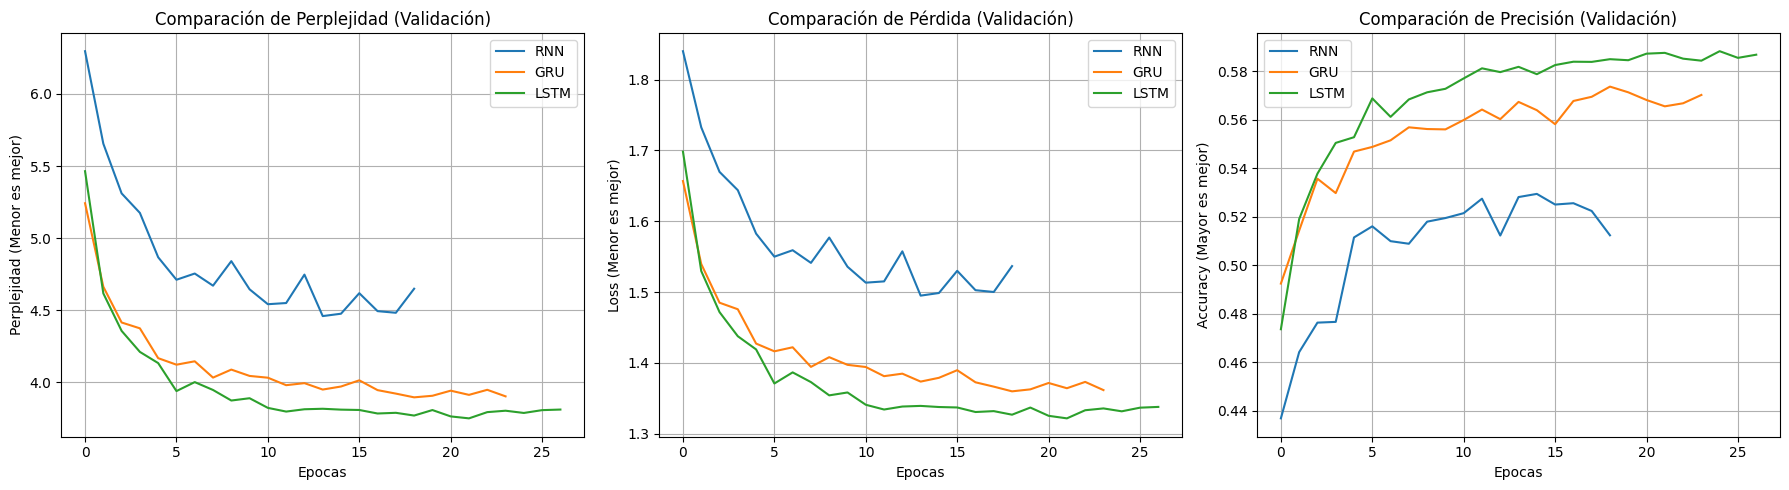

In [10]:
# Visualización de Resultados Comparativos
plt.figure(figsize=(18, 5))

# Gráfica de Perplejidad (La métrica más importante)
plt.subplot(1, 3, 1)
for m_type in model_types:
    # Filtramos valores infinitos o muy grandes para una mejor visualización
    ppl = np.array(histories[m_type]['val_ppl'])
    ppl = np.where(ppl > 100, 100, ppl) # Cap en 100 para visualización
    plt.plot(ppl, label=f"{m_type.upper()}")
plt.title("Comparación de Perplejidad (Validación)")
plt.xlabel("Epocas")
plt.ylabel("Perplejidad (Menor es mejor)")
plt.legend()
plt.grid(True)

# Gráfica de Pérdida
plt.subplot(1, 3, 2)
for m_type in model_types:
    plt.plot(histories[m_type]['val_loss'], label=f"{m_type.upper()}")
plt.title("Comparación de Pérdida (Validación)")
plt.xlabel("Epocas")
plt.ylabel("Loss (Menor es mejor)")
plt.legend()
plt.grid(True)

# Gráfica de Precisión (Accuracy) - NUEVO
plt.subplot(1, 3, 3)

try:
    for m_type in model_types:
        plt.plot(histories[m_type].get('val_acc', []), label=f"{m_type.upper()}")
    plt.title("Comparación de Precisión (Validación)")
    plt.xlabel("Epocas")
    plt.ylabel("Accuracy (Mayor es mejor)")
    plt.legend()
    plt.grid(True)
except KeyError:
    print("Advertencia: La métrica 'val_acc' no se encontró en el historial.")

plt.tight_layout()
plt.show()

## Conclusiones y análisis de resultados

Tras realizar el entrenamiento y evaluación comparativa de las tres arquitecturas recurrentes (Simple RNN, GRU y LSTM) sobre el corpus de *Don Quijote*, se derivan las siguientes conclusiones:

### Rendimiento general

Las arquitecturas con compuertas (LSTM y GRU) superaron consistentemente a la Simple RNN en todas las métricas.

* **RNN simple:** se estancó con una perplejidad de validación superior a 4.4 y una precisión del ~52%.
* **Modelos con compuertas:** lograron reducir la perplejidad por debajo de 3.9 y alcanzar una precisión cercana al 58%.

 esto confirma empíricamente que las celdas simples tienen dificultades severas para capturar dependencias a largo plazo (esenciales para la compleja estructura gramatical de Cervantes) debido al problema del desvanecimiento del gradiente. Por el contrario, los mecanismos de memoria interna de LSTM y GRU lograron retener el contexto eficazmente.

### LSTM vs GRU

Se observó un rendimiento altamente competitivo entre ambas. Si bien la LSTM obtuvo las mejores métricas absolutas (menor Loss de 1.32), la GRU se mantuvo muy cerca (Loss 1.36) con una ventaja notable en eficiencia: su entrenamiento fue aproximadamente un 35% más rápido en tiempo total.

 esto posiciona a la **GRU** como la alternativa ideal cuando los recursos computacionales son limitados. Por otro lado, mantenemos la **LSTM** como la opción preferida cuando se busca maximizar la calidad de la predicción sin restricciones de tiempo.

## Generación de texto: estrategias de búsqueda

Una vez entrenado el modelo, este puede predecir la distribución de probabilidad del siguiente carácter dado un contexto. Para construir secuencias completas, necesitamos un método para seleccionar caracteres paso a paso. Implementamos tres estrategias:

**Búsqueda voraz (greedy search)**

En cada paso, selecciona el carácter con la probabilidad más alta. Es un método rápido pero determinista. Su mayor desventaja es que a menudo produce texto repetitivo o cae en bucles locales, ya que no considera el contexto global, solo el inmediato.

**Beam search (determinista)**

Mantiene las $k$ mejores secuencias parciales (el "haz" o beam) en cada paso, en lugar de solo la mejor. a diferencia de la búsqueda voraz, esta estrategia explora un espacio de soluciones más amplio. Esto nos permite encontrar secuencias que son *globalmente* más probables, evitando caminos que parecen buenos al principio pero que llevan a callejones sin salida gramaticales.

**Muestreo con temperatura (stochastic sampling)**

En lugar de elegir siempre lo más probable, muestrea el siguiente carácter aleatoriamente según la distribución de probabilidad ajustada por una temperatura ($T$).

* **Temperatura ($T$):** actúa como un controlador de creatividad.
    * **$T < 1.0$ (baja):** afila la distribución, haciendo que el modelo sea más conservador y confiado (similar a la búsqueda voraz).
    * **$T > 1.0$ (alta):** aplana la distribución, permitiendo que caracteres menos probables sean elegidos. Esto aumenta la diversidad y originalidad, pero incrementa el riesgo de errores ortográficos.

In [11]:
import torch.nn.functional as F
import glob

# Función auxiliar
def decode_indices(indices):
    return "".join([idx2char[idx] for idx in indices])

# --- Greedy Search ---
def generate_greedy(model, start_text, length=100, temp=1.0):
    model.eval()
    text_idx = [char2idx[c] for c in start_text]
    input_seq = torch.tensor(text_idx, dtype=torch.long).unsqueeze(0).to(device)
    generated_text = start_text

    with torch.no_grad():
        for _ in range(length):
            output = model(input_seq)
            probs = F.softmax(output / temp, dim=-1)
            next_idx = torch.argmax(probs).item()

            generated_text += idx2char[next_idx]
            text_idx.append(next_idx)
            input_seq = torch.tensor(text_idx[-max_context_size:], dtype=torch.long).unsqueeze(0).to(device)
    return generated_text

# --- Beam Search (Genérico) ---
def generate_beam_search(model, start_text, length=100, beam_width=5, temp=1.0, stochastic=False):
    model.eval()
    text_idx = [char2idx[c] for c in start_text]
    beam = [(text_idx, 0.0)]

    with torch.no_grad():
        for _ in range(length):
            candidates = []
            for seq, score in beam:
                input_tensor = torch.tensor(seq[-max_context_size:], dtype=torch.long).unsqueeze(0).to(device)
                output = model(input_tensor)
                log_probs = F.log_softmax(output / temp, dim=-1).squeeze()

                if stochastic:
                    # Temperatura aplicada antes del softmax
                    probs = torch.exp(log_probs / temp)
                    # Normalizar
                    if probs.sum() == 0: probs = torch.ones_like(probs)
                    probs = probs / probs.sum()

                    top_k_indices = torch.multinomial(probs, beam_width * 2, replacement=True)
                    top_k_indices = list(set(top_k_indices.tolist()))[:beam_width]
                else:
                    top_k_log_probs, top_k_indices = torch.topk(log_probs, beam_width)
                    top_k_indices = top_k_indices.tolist()

                for idx in top_k_indices:
                    new_seq = seq + [idx]
                    new_score = score + log_probs[idx].item()
                    candidates.append((new_seq, new_score))

            candidates.sort(key=lambda x: x[1], reverse=True)
            beam = candidates[:beam_width]

    return decode_indices(beam[0][0])

# --- Ejecución ---
seed_text = "en un lugar de la mancha"
gen_length = 200
model_types = ['rnn', 'gru', 'lstm']

print(f"Semilla: '{seed_text}'")
print("=" * 80)

for m_type in model_types:
    print(f"\n>>> Modelo: {m_type.upper()} <<<")

    # Buscar archivo
    files = glob.glob(f"*model_{m_type}*.pth")
    if not files:
        print(f"Saltando {m_type} (no encontrado)")
        continue

    try:
        path = files[0]
        print(f"(Cargando {path}...)")
        # Instanciar y cargar
        model_gen = CharRNN(vocab_size, HIDDEN_DIM, rnn_type=m_type, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
        model_gen.load_state_dict(torch.load(path, map_location=device))
        model_gen.eval()

        # Pruebas
        print(f"\n1. Greedy:")
        print(generate_greedy(model_gen, seed_text, length=gen_length))

        print(f"\n2. Estocástico (T=0.8):")
        print(generate_beam_search(model_gen, seed_text, length=gen_length, beam_width=5, temp=0.8, stochastic=True))

        print(f"\n3. Alta Creatividad (T=3):")
        print(generate_beam_search(model_gen, seed_text, length=gen_length, beam_width=5, temp=3, stochastic=True))

    except Exception as e:
        print(f"Error: {e}")

    print("-" * 80)

Semilla: 'en un lugar de la mancha'

>>> Modelo: RNN <<<
(Cargando best_model_rnn.pth...)

1. Greedy:
en un lugar de la mancha, por la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la parte de la

2. Estocástico (T=0.8):
en un lugar de la mancha, porque se puede de la mancha, porque, porque de la parte de la mancha, porque le parece que parece, porque se puede de la mancha, porque, porque de la parte de la mancha, porque, porque le parece qu

3. Alta Creatividad (T=3):
en un lugar de la manchass, lo una, poy por tallaron quto., pero más pono, o raz postal, sus vultura; quustos, pontro pacre, y por lo quo,no
podraron purso,, los puvo; poro por aqullasmo, o,
y, pasoso,, quo tal y pertos,
son
--------------------------------------------------------------------------------

>>> Modelo: GRU <<<
(Cargando best_model_gru.pth...)

1. Greedy:
en un lugar de la manch


La calidad del texto generado depende críticamente de la estrategia de decodificación (*sampling*).

* **Greedy search ($T=1.0$):** tiende a la repetición degenerada. Al elegir siempre la opción más probable, el modelo cae en bucles locales (ej. RNN: "en el cual en el cual"). Esto nos indica que el modelo aprende probabilidades de transición locales fuertes, pero le falta coherencia global con esta estrategia.
* **Beam search determinista:** mejora ligeramente la coherencia al explorar múltiples caminos, pero aún sufre de repeticiones. Sigue siendo demasiado conservador.
* **Beam search estocástico ($T=0.8$):** esta fue la **estrategia ganadora**.
    * **Por qué funcionó mejor:** logra romper los bucles de repetición introduciendo la variedad necesaria. Produce el texto más natural y parecido al estilo de Cervantes, manteniendo la coherencia gramatical mejor que las temperaturas altas.
* **Alta temperatura ($T=3$):** degrada la calidad. El texto se vuelve incoherente, mostrando que el modelo empieza a elegir caracteres de baja probabilidad y rompe la estructura de las palabras.

> **Conclusión general:** para modelar un lenguaje literario complejo como el de Cervantes a nivel de caracteres, la arquitectura **LSTM** se presenta como la más robusta (logrando reducir la perplejidad de a ~3.8). Sin embargo, el modelo por sí solo no basta: la generación de texto requiere obligatoriamente estrategias estocásticas (*temperature sampling*) para evitar la degeneración repetitiva típica de los modelos recurrentes.